# Generative Audio Analogy ConvNet
This notebook has a model trained on an audio analogy task:
`A : B :: C : ?`, where D must be generated to reflect the same interval transformation A→B, applied to C.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [2]:
# config

SAMPLE_RATE = 16000
DURATION = 1.0  # seconds
EPOCHS = 200
N_SAMPLES = int(SAMPLE_RATE * DURATION)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
TRAIN_INTERVALS = [1, 3, 5, 7] # e.g., major second, minor third, perfect fourth, etc.
TEST_INTERVALS = list(range(1, 13)) # all 12 Western semitones

In [3]:
# utilities for audio

def synthesize_note(freq, duration=1.0, sample_rate=16000):
    t = torch.linspace(0, duration, int(sample_rate * duration))
    waveform = 0.5 * torch.sin(2 * np.pi * freq * t)
    return waveform.unsqueeze(0)  # [1, N]

def note_to_freq(midi_note):
    return 440.0 * (2 ** ((midi_note - 69) / 12.0))

def interval_pair(base_note, interval):
    note1 = base_note
    note2 = base_note + interval
    return note_to_freq(note1), note_to_freq(note2)

In [4]:
# model

class AudioAnalogyNet(nn.Module):
    def __init__(self):
        super(AudioAnalogyNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
        )
        with torch.no_grad():
            dummy = torch.randn(1, 1, N_SAMPLES)
            dummy_out = self.conv(dummy)
            self.flat_dim = dummy_out.view(1, -1).size(1)

        self.linear = nn.Sequential(
            nn.Linear(3 * self.flat_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, N_SAMPLES),
        )

    def forward(self, A, B, C):
        A_enc = self.conv(A).flatten(1)
        B_enc = self.conv(B).flatten(1)
        C_enc = self.conv(C).flatten(1)
        combined = torch.cat((A_enc, B_enc, C_enc), dim=1)
        return self.linear(combined).unsqueeze(1)

In [5]:
# generate dataset

def generate_example(interval, base_note_range=(40, 70)):
    base_AB = random.randint(*base_note_range)
    base_CD = random.randint(*base_note_range)
    fA, fB = interval_pair(base_AB, interval)
    fC, fD = interval_pair(base_CD, interval)
    A = synthesize_note(fA)
    B = synthesize_note(fB)
    C = synthesize_note(fC)
    D = synthesize_note(fD)
    return A, B, C, D

In [6]:
# training loop

def train_model(model, epochs=10, batch_size=16, steps_per_epoch=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for _ in range(steps_per_epoch):
            interval = random.choice(TRAIN_INTERVALS)
            batch = [generate_example(interval) for _ in range(batch_size)]
            A, B, C, D = zip(*batch)
            A = torch.stack(A).to(device)
            B = torch.stack(B).to(device)
            C = torch.stack(C).to(device)
            D = torch.stack(D).to(device)

            pred_D = model(A, B, C)
            loss = loss_fn(pred_D, D)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / steps_per_epoch:.4f}")


In [7]:
# evaluation

def evaluate_model(model, n_samples):
    model.eval()
    results = {}
    with torch.no_grad():
        for interval in TEST_INTERVALS:
            losses = []
            for _ in range(n_samples):
                A, B, C, D = generate_example(interval)
                A = A.unsqueeze(0).to(device)
                B = B.unsqueeze(0).to(device)
                C = C.unsqueeze(0).to(device)
                D = D.unsqueeze(0).to(device)
                pred_D = model(A, B, C)
                loss = F.mse_loss(pred_D, D)
                losses.append(loss.item())
            results[interval] = np.mean(losses)
    return results

In [8]:
# visualizations

def visualize_results(results, model):
    # Plot MSE per interval
    plt.figure(figsize=(10, 5))
    bars = plt.bar(results.keys(), results.values(), color=["green" if i in TRAIN_INTERVALS else "gray" for i in results.keys()])
    plt.axhline(np.mean([results[i] for i in TRAIN_INTERVALS]), linestyle="--", color="blue", label="Train Mean")
    plt.axhline(np.mean([results[i] for i in TEST_INTERVALS if i not in TRAIN_INTERVALS]), linestyle="--", color="red", label="Held-Out Mean")
    plt.xlabel("Interval (Semitones)")
    plt.ylabel("MSE")
    plt.title("Generalization Across Musical Intervals")
    plt.legend()
    plt.tight_layout()
    #plt.savefig("interval_generalization_plot.png")

    # Audio + waveform comparison
    SILENCE = torch.zeros(1, int(0.25 * SAMPLE_RATE)) # Silence = 0.25 seconds of zeroed audio

    for interval in [2, 7, 11]:
        A, B, C, D_true = generate_example(interval)
        A = A.to(device).unsqueeze(0)
        B = B.to(device).unsqueeze(0)
        C = C.to(device).unsqueeze(0)
        D_pred = model(A, B, C).squeeze().detach().cpu()

        # Remove extra batch/channel dims for concatenation
        A = A.squeeze().cpu()
        B = B.squeeze().cpu()
        C = C.squeeze().cpu()
        D_true = D_true.squeeze()
        
        # Concatenate: true sequence + silence + model prediction
        full_sequence = torch.cat([A, B, C, D_true, SILENCE.squeeze(), D_pred], dim=-1)

        print(f"Interval {interval} — True A:B::C:D followed by Predicted D")
        display(Audio(full_sequence.numpy(), rate=SAMPLE_RATE))

        # Plot
        plt.figure()
        plt.plot(D_true.squeeze().numpy(), label="True D")
        plt.plot(D_pred.numpy(), label="Predicted D", alpha=0.75)
        plt.title(f"Waveform Comparison for Interval {interval}")
        plt.legend()
        plt.tight_layout()
        #plt.savefig(f"samples/waveform_comparison_interval_{interval}.png")

In [9]:
model = AudioAnalogyNet().to(device)
train_model(model, epochs = EPOCHS)

Epoch 1: Loss = 0.1468
Epoch 2: Loss = 0.1177
Epoch 3: Loss = 0.1149
Epoch 4: Loss = 0.1135
Epoch 5: Loss = 0.1125
Epoch 6: Loss = 0.1116
Epoch 7: Loss = 0.1110
Epoch 8: Loss = 0.1104
Epoch 9: Loss = 0.1100
Epoch 10: Loss = 0.1100
Epoch 11: Loss = 0.1098
Epoch 12: Loss = 0.1086
Epoch 13: Loss = 0.1081
Epoch 14: Loss = 0.1087
Epoch 15: Loss = 0.1079
Epoch 16: Loss = 0.1077
Epoch 17: Loss = 0.1073
Epoch 18: Loss = 0.1070
Epoch 19: Loss = 0.1060
Epoch 20: Loss = 0.1062
Epoch 21: Loss = 0.1055
Epoch 22: Loss = 0.1046
Epoch 23: Loss = 0.1046
Epoch 24: Loss = 0.1050
Epoch 25: Loss = 0.1038
Epoch 26: Loss = 0.1028
Epoch 27: Loss = 0.1022
Epoch 28: Loss = 0.1018
Epoch 29: Loss = 0.1023
Epoch 30: Loss = 0.1010
Epoch 31: Loss = 0.1005
Epoch 32: Loss = 0.1010
Epoch 33: Loss = 0.0979
Epoch 34: Loss = 0.1006
Epoch 35: Loss = 0.0992
Epoch 36: Loss = 0.0991
Epoch 37: Loss = 0.1001
Epoch 38: Loss = 0.0998
Epoch 39: Loss = 0.0986
Epoch 40: Loss = 0.0994
Epoch 41: Loss = 0.0967
Epoch 42: Loss = 0.0983
E

Interval 7 — True A:B::C:D followed by Predicted D


Interval 11 — True A:B::C:D followed by Predicted D


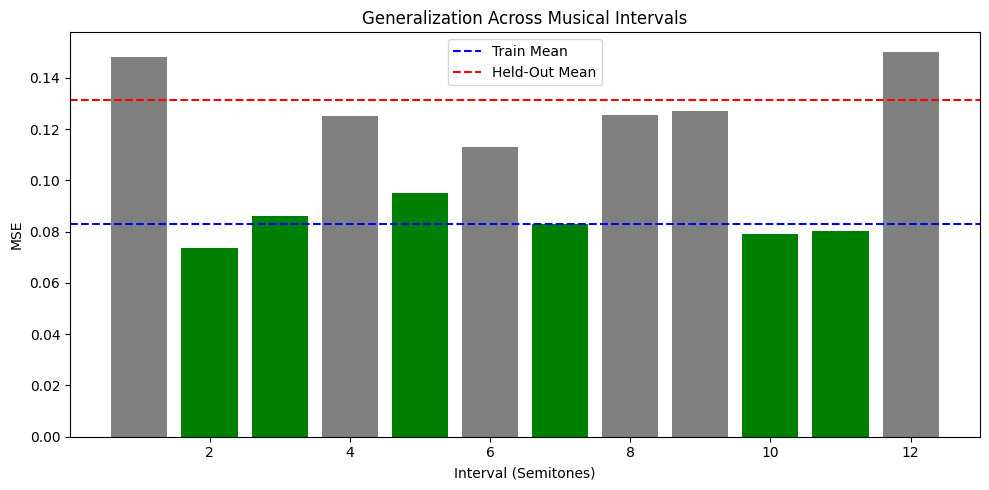

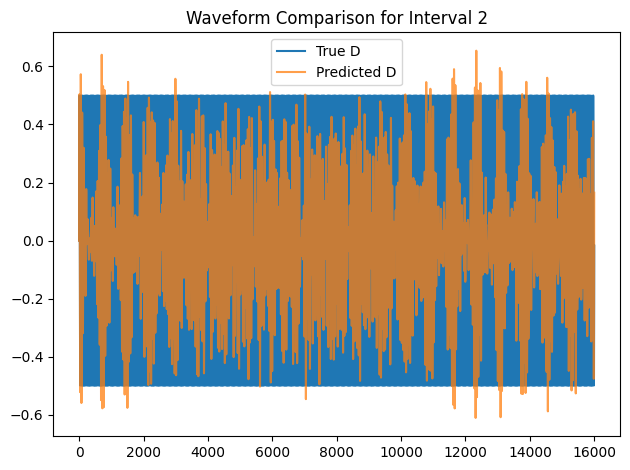

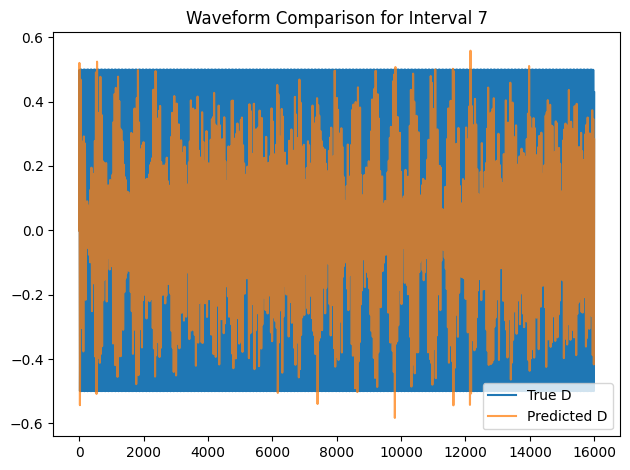

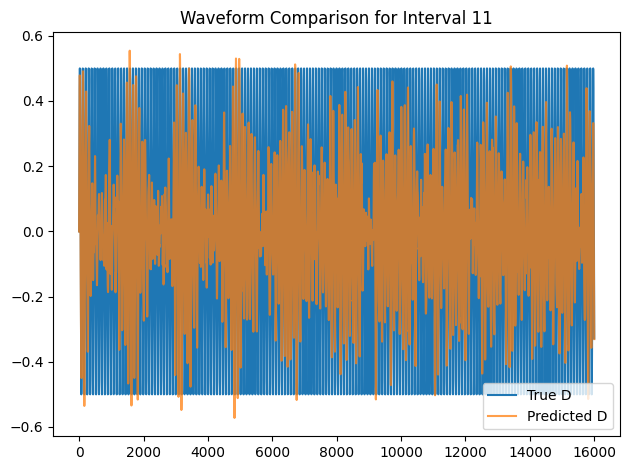

In [10]:
results = evaluate_model(model)
for interval, loss in results.items():
    print(f"Interval {interval}: MSE = {loss:.4f}")
visualize_results(results, model)